In [2]:
import pandas as pd
import numpy as np
from DataLoader import DataLoader, SyntheticDataLoader
from river import stream
from river import tree
from river import metrics
from river import preprocessing
from river import feature_selection
from river import drift
from river import stats
from river import ensemble
from river import forest
from collections import deque, Counter
from river import base
from typing import Dict, List
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import warnings
from itertools import product
import matplotlib.pyplot as plt
from pandasql import sqldf
import seaborn as sns
import matplotlib.pyplot as plt
from classification import TStatFeatureSelector

pd.options.display.max_columns = 500

class BollingerBandDriftDetector:
    def __init__(self, window_size=20, num_std=3.5, next_drift_delay=100):
        self.window_size = window_size
        self.num_std = num_std
        self.values = deque(maxlen=window_size)
        self.drift_detected = False
        self.next_drift_delay = next_drift_delay
        self.current_next_drift_delay = 0

    def update(self, value: float):
        self.values.append(value)
        self.drift_detected = False  # Reset flag
        self.current_next_drift_delay = max(0, self.current_next_drift_delay - 1)
        
        if len(self.values) < self.window_size:
            return  # Not enough data yet
        
        mean = np.mean(self.values)
        std = np.std(self.values)
        upper_band = mean + self.num_std * std
        lower_band = mean - self.num_std * std

        # If current value is outside bands -> drift
        if (value > upper_band or value < lower_band) and self.current_next_drift_delay == 0:
            self.drift_detected = True
            self.current_next_drift_delay = self.next_drift_delay # min of instances between next drifts

class FixedSizeBuffer:
    def __init__(self, max_size, num_features):
        self.max_size = max_size
        self.buffer = np.empty((0, num_features))
        self.labels = []

    def append(self, x):
        if len(self.buffer) >= self.max_size:
            self.buffer = np.delete(self.buffer, 0, axis=0)
            self.labels.pop(0)
        self.buffer = np.vstack([self.buffer, x])

    def append_label(self, y):
        self.labels.append(y)

    def get_data(self):
        return self.buffer, np.array(self.labels)

class StockPredictor:

    def __init__(self, stock_data, model_name, drift_name, feature_selector_name, 
                 provided_model=None, provided_detector=None, provided_feature_selector=None,
                 learning_threshold = 1000):
        self.stock_data = stock_data
        self.data_stream = StockPredictor.ohlc_stream(stock_data)
        self.metric = metrics.ClassificationReport()
        self.learning_threshold = learning_threshold
        self.drifts_detected = 0

        self.model_name = model_name
        self.provided_model = provided_model
        if provided_model:
            self.model = provided_model
            self.is_incremental = hasattr(provided_model, 'learn_one')
        else:
            self.model, self.is_incremental = StockPredictor.get_model(model_name)

        if self.is_incremental:
            self.feature_selector_name = feature_selector_name
            self.feature_selector = provided_feature_selector or StockPredictor.get_feature_selector(feature_selector_name)
            self.pipeline = StockPredictor.get_pipeline(self.model, self.feature_selector)
            
        else:
            self.feature_selector_name = feature_selector_name
            self.feature_selector = provided_feature_selector or StockPredictor.get_feature_selector(feature_selector_name)
            self.pipeline = StockPredictor.get_sklearn_pipeline(self.model, self.feature_selector)

        self.drift_name = drift_name
        self.drift_detector = provided_detector or StockPredictor.get_drift_detector(drift_name)

    @staticmethod
    def ohlc_stream(df):
        for _, row in df.iterrows():
            features = row.iloc[:-1].to_dict()
            yield features, row['target']

    @staticmethod
    def get_model(name: str):
        name = name.lower()
        if name == 'hoeffdingtreeclassifier':
            return tree.HoeffdingTreeClassifier(), True
        if name == 'extremelyfastdecisiontreeclassifier':
            return tree.ExtremelyFastDecisionTreeClassifier(), True
        else:
            raise ValueError(f"Unknown model")

    @staticmethod
    def get_drift_detector(name: str):
        name = name.lower()
        if name == "adwin":
            return drift.ADWIN()
        elif name == "kswin":
            return drift.KSWIN()
        elif name == "dummydriftdetector":
            return drift.DummyDriftDetector()
        elif name == "pagehinkley":
            return drift.PageHinkley()
        elif name == 'bollingerband':
            return BollingerBandDriftDetector()
        else:
            raise ValueError(f"Unknown detector")

    @staticmethod
    def get_feature_selector(name: str):
        name = name.lower()
        if name == "selectkbest":
            return feature_selection.SelectKBest(similarity=stats.PearsonCorr(), k=15)
        elif name == 'selectkbest_sklearn':
            return SelectKBest(score_func=f_classif, k=15)
        elif name == 'tstat':
            return TStatFeatureSelector(k=15, update_interval=100)
        elif name == 'ewa':
            return EWA(alpha=0.3, n=15)
        else:
            raise ValueError(f"Unknown selector")

    @staticmethod
    def get_pipeline(model, feature_selector):
        scaler = preprocessing.StandardScaler()
        pipeline = scaler | feature_selector | model
        return pipeline

    @staticmethod
    def get_sklearn_pipeline(model, feature_selector):
        scaler = MinMaxScaler()
        selector = feature_selector
        model = model
        pipeline = Pipeline([
            ('scaler', scaler),
            ('selector', selector),
            ('mlp', model)
        ])
    
        return pipeline
    
    def prediction(self):

        if self.is_incremental:
            for i, (x, y) in enumerate(self.data_stream):
                close_value = float(self.stock_data.loc[i, 'close'])
                if i >= self.learning_threshold:

                    y_pred = self.pipeline.predict_one(x)
                    self.pipeline.learn_one(x, y)

                    error = int(y_pred != y) if y_pred is not None else 0
                    if self.drift_name == 'bollingerband':
                        self.drift_detector.update(close_value)
                    else:
                        self.drift_detector.update(error)

                    if y_pred is not None:
                        self.metric.update(y, y_pred)

                    if self.drift_detector.drift_detected:
                        self.drifts_detected += 1
                        # print(f'Drift detected at index {i}! ({self.drift_name})')

                        # resets model
                        if self.provided_model:
                            self.model = self.provided_model
                        else:
                            self.model, _ = StockPredictor.get_model(self.model_name)

                        self.pipeline = StockPredictor.get_pipeline(self.model, self.feature_selector)
        
        else:

            buffer = FixedSizeBuffer(max_size=self.learning_threshold, num_features=self.stock_data.shape[1] - 1)
            for i, (x, y) in enumerate(self.data_stream):
                close_value = float(self.stock_data.loc[i, 'close'])
                x_array = np.array(list(x.values())).reshape(1, -1)
                buffer.append(x_array[0])
                buffer.append_label(y)
                
                if i >= self.learning_threshold and (i % self.learning_threshold == 0 or self.drift_detector.drift_detected):
                    X_train, y_train = buffer.get_data()
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore")
                        self.pipeline.fit(X_train, y_train) # MLP produces warnings!

                if i >= self.learning_threshold:
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore")
                        y_pred = self.pipeline.predict(x_array)[0]
                    error = int(y_pred != y)
                    if self.drift_name == 'bollingerband':
                        self.drift_detector.update(close_value)
                    else:
                        self.drift_detector.update(error)
                        
                    self.metric.update(y, y_pred)

                    if self.drift_detector.drift_detected:
                        self.drifts_detected += 1
                        # print(f'Drift detected at index {i}! ({self.drift_name})')


        accuracy, metrics_result = self.get_metrics()
        # print(f'accuracy: {accuracy}')
        # display(metrics_result)
        return accuracy, metrics_result

    def get_metrics(self):

        classes = sorted(self.metric.cm.classes)

        for c in classes:
            if c not in self.metric._f1s:
                self.metric._f1s[c] = metrics.F1(cm=self.metric.cm, pos_val=c)
        
        accuracy = round(self.metric._accuracy.get(), 3)

        # print(self.metric._f1s)
        metrics_result = pd.DataFrame([ [0, self.metric._f1s[0].precision.get(), self.metric._f1s[0].recall.get(), self.metric._f1s[0].get()],
                                        [1, self.metric._f1s[1].precision.get(), self.metric._f1s[1].recall.get(), self.metric._f1s[1].get()]],
                                        columns=['class', 'precision', 'recall', 'f1'])
        
        metrics_result = metrics_result.round(3)

        return accuracy, metrics_result

class NoChangeClassifier(base.Classifier):
    def __init__(self):
        self.last_label = None

    def learn_one(self, x, y):
        self.last_label = y
        return self

    def predict_one(self, x):
        return self.last_label

class MajorityClassClassifier(base.Classifier):
    def __init__(self, window_size=100):
        self.window_size = window_size
        self.window = deque()
        self.class_counts = Counter()
        self.majority_class = None

    def learn_one(self, x, y):
        self.window.append(y)
        self.class_counts[y] += 1

        if len(self.window) > self.window_size:
            old_y = self.window.popleft()
            self.class_counts[old_y] -= 1
            if self.class_counts[old_y] == 0:
                del self.class_counts[old_y]

        if self.class_counts:
            self.majority_class = self.class_counts.most_common(1)[0][0]

        return self

    def predict_one(self, x):
        return self.majority_class

class StockPredictor_Naive:

    def __init__(self, stock_data, model_name, drift_name, provided_model=None, provided_detector=None, learning_threshold = 1000):
        self.stock_data = stock_data
        self.data_stream = StockPredictor_Naive.ohlc_stream(stock_data)
        self.metric = metrics.ClassificationReport()
        self.learning_threshold = learning_threshold
        self.drifts_detected = 0

        self.model_name = model_name
        self.provided_model = provided_model

        if provided_model:
            self.model = provided_model
        else:
            self.model= StockPredictor_Naive.get_model(model_name)

        self.drift_name = drift_name
        self.drift_detector = provided_detector or StockPredictor_Naive.get_drift_detector(drift_name)
        self.drift_days = []

    @staticmethod
    def ohlc_stream(df):
        for _, row in df.iterrows():
            features = row.iloc[:-1].to_dict()
            yield features, row['target']

    @staticmethod
    def get_model(name: str):
        name = name.lower()
        if name == 'nochange':
            return NoChangeClassifier()
        if name == 'majorityclass':
            return MajorityClassClassifier()
        else:
            raise ValueError(f"Unknown model")

    @staticmethod
    def get_drift_detector(name: str):
        name = name.lower()
        if name == "adwin":
            return drift.ADWIN()
        elif name == "kswin":
            return drift.KSWIN()
        elif name == "dummydriftdetector":
            return drift.DummyDriftDetector()
        elif name == "pagehinkley":
            return drift.PageHinkley()
        elif name == 'bollingerband':
            return BollingerBandDriftDetector()
        else:
            raise ValueError(f"Unknown detector")

    def prediction(self):
        for i, (x, y) in enumerate(self.data_stream):
            close_value = float(self.stock_data.loc[i, 'close'])

            if i >= self.learning_threshold:
                y_pred = self.model.predict_one(x)
                
                self.model.learn_one(x, y)

                error = int(y_pred != y) if y_pred is not None else 0
                if self.drift_name == 'bollingerband':
                    self.drift_detector.update(close_value)
                else:
                    self.drift_detector.update(error)

                if y_pred is not None:
                    self.metric.update(y, y_pred)

                if self.drift_detector.drift_detected:
                    self.drifts_detected += 1
                    # print(f'Drift detected at index {i}! ({self.drift_name})')
                    self.drift_days.append(i)

                    # resets model
                    if self.provided_model:
                        self.model = self.provided_model
                    else:
                        self.model, _ = StockPredictor_Naive.get_model(self.model_name)        

        accuracy, metrics_result = self.get_metrics()
        # print(f'accuracy: {accuracy}')
        # display(metrics_result)
        return accuracy, metrics_result

    def get_metrics(self):

        classes = sorted(self.metric.cm.classes)

        for c in classes:
            if c not in self.metric._f1s:
                self.metric._f1s[c] = metrics.F1(cm=self.metric.cm, pos_val=c)
        
        accuracy = round(self.metric._accuracy.get(), 3)

        # print(self.metric._f1s)
        metrics_result = pd.DataFrame([ [0, self.metric._f1s[0].precision.get(), self.metric._f1s[0].recall.get(), self.metric._f1s[0].get()],
                                        [1, self.metric._f1s[1].precision.get(), self.metric._f1s[1].recall.get(), self.metric._f1s[1].get()]],
                                        columns=['class', 'precision', 'recall', 'f1'])
        
        metrics_result = metrics_result.round(3)

        return accuracy, metrics_result


### DATA LOADING

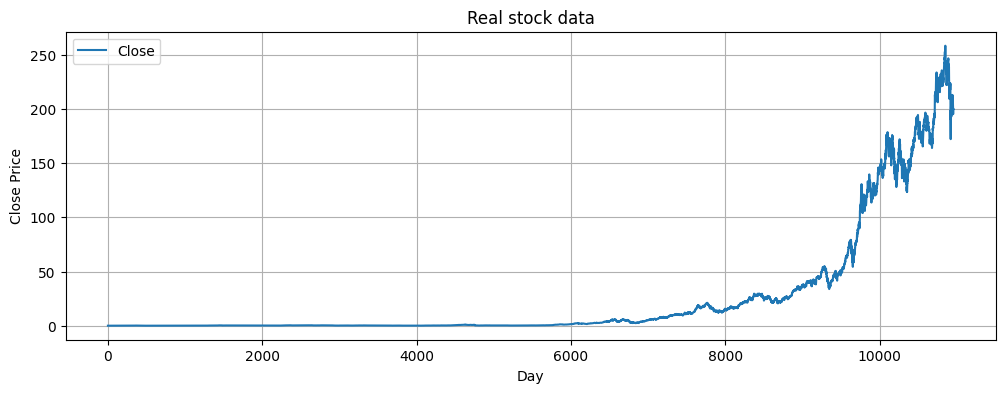

In [5]:
ticker = 'AAPL'
dataLoader = DataLoader()
stock_data = dataLoader.pipeline(ticker)

plt.figure(figsize=(12, 4))
plt.plot(stock_data.index, stock_data['close'], label=f"Close")
plt.title("Real stock data")
plt.xlabel("Day")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()

In [6]:
stock_data

,open,close,high,low,volume,max_5,min_5,max_10,min_10,max_20,min_20,max_40,min_40,max_80,min_80,max_125,min_125,max_250,min_250,max_500,min_500,max_lifetime,min_lifetime,sma_5,sma_10,sma_20,sma_50,sma_100,sma_200,daily_return,1_week_return,2_weeks_return,1_month_return,6_months_return,12_months_return,day_variation,day_change,downward_pressure,upward_pressure,rsi,macd,ppo,stochastic_fast,stochastic_slow,%r,atr,cmo,cci,mom,bias,wnr,target
0,0.064731,0.064731,0.065159,0.064731,34272000,0.065588,0.063445,0.065588,0.063016,0.066875,0.061301,0.068589,0.061301,0.07459,0.04887,0.111028,0.04887,0.12346,0.04887,0.12346,0.04887,0.12346,0.04887,0.064645,0.064302,0.063959,0.063668,0.067895,0.081025,0.006668,0.006668,0.048610,0.027210,-0.376037,-0.343479,0.006622,0.000000,-0.006579,0.000000,50.000000,0.000137,0.213126,69.989569,73.320850,42.869246,0.001194,33.333664,38.813424,0.003001,0.666723,-0.333332,0
1,0.064731,0.064731,0.065159,0.064731,37408000,0.065588,0.064302,0.065588,0.063445,0.066875,0.061301,0.068589,0.061301,0.07459,0.04887,0.108885,0.04887,0.12346,0.04887,0.12346,0.04887,0.12346,0.04887,0.064902,0.064473,0.063959,0.063916,0.067719,0.080909,0.000000,0.020270,0.027210,0.000000,-0.351932,-0.307343,0.006622,0.000000,-0.006579,0.000000,50.000000,0.000160,0.249296,69.989569,66.656087,50.011920,0.001194,22.222523,38.750027,0.001715,0.398999,-0.388887,0
2,0.064731,0.064302,0.065159,0.064302,76092800,0.065588,0.064302,0.065588,0.063445,0.065588,0.061301,0.068589,0.061301,0.07459,0.04887,0.107171,0.04887,0.12346,0.04887,0.12346,0.04887,0.12346,0.04887,0.064731,0.064431,0.063830,0.064156,0.067586,0.080776,-0.006624,-0.013158,-0.006624,-0.038471,-0.367089,-0.257428,0.013333,-0.006622,-0.013157,0.000000,46.666609,0.000142,0.221618,59.989123,66.656087,66.677510,0.001194,-6.667964,31.133401,-0.000429,-0.199637,-0.533340,0
3,0.063016,0.062159,0.063016,0.062159,25244800,0.064731,0.062159,0.065588,0.062159,0.065588,0.061301,0.068589,0.061301,0.07459,0.04887,0.106742,0.04887,0.12346,0.04887,0.12346,0.04887,0.12346,0.04887,0.064045,0.064259,0.063830,0.064268,0.067410,0.080631,-0.033331,-0.052284,-0.026844,0.000000,-0.372295,-0.299516,0.013792,-0.013605,-0.013605,0.000000,50.000000,-0.000044,-0.068956,9.998795,46.659162,100.000000,0.001133,-22.221884,-88.316816,-0.001715,-3.268659,-0.611109,1
4,0.063873,0.063873,0.064302,0.063873,31315200,0.064731,0.062159,0.065588,0.062159,0.065588,0.06173,0.068589,0.061301,0.07459,0.04887,0.103741,0.04887,0.12346,0.04887,0.12346,0.04887,0.12346,0.04887,0.063959,0.064259,0.063959,0.064379,0.067226,0.080500,0.027584,-0.006666,0.000000,0.041955,-0.368644,-0.300474,0.006711,0.000000,-0.006666,0.000000,58.064437,-0.000053,-0.082776,44.435696,38.141205,55.564304,0.001255,0.000000,-7.832920,0.000000,-0.600379,-0.500000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10951,200.710007,201.360001,202.750000,199.699997,46742400,211.259995,201.360001,212.929993,198.270004,213.040634,195.992981,223.596786,172.194199,246.776398,172.194199,258.396667,172.194199,258.396667,172.194199,258.396667,164.00946,258.396667,0.037724,206.069998,207.611998,206.318570,206.546597,221.357018,225.457593,-0.003612,-0.047718,0.020933,-0.032375,-0.141301,0.059726,0.015273,0.003238,-0.006856,0.008312,45.051124,-0.244382,-0.118615,39.932454,49.496742,75.516075,5.175482,15.140598,-53.982399,4.128632,-3.011385,-0.424297,0
10952,193.669998,195.270004,197.699997,193.460007,78432900,208.779999,195.270004,212.929993,195.270004,213.040634,195.270004,223.596786,172.194199,246.776398,172.194199,258.396667,172.194199,258.396667,172.194199,258.396667,164.00946,258.396667,0.037724,202.872000,207.311998,205.631774,206.263889,220.759969,225.402617,-0.030244,-0.075689,-0.015131,-0.065720,-0.166811,0.049782,0.021917,0.008262,-0.012291,0.009356,45.488575,-1.065059,-0.518953,10.853671,31.401398,91.16

### GRID SEARCH REPORT

In [ ]:
# Drift detectors - default values for overview
adwin_detector = drift.ADWIN(delta=0.002, clock=32, max_buckets=5, min_window_length=5, grace_period=10)
kswin_detector = drift.KSWIN(alpha = 0.005, window_size = 100, stat_size = 30)
page_hinley_detector = drift.PageHinkley(min_instances = 30, delta = 0.005, threshold = 50.0, alpha = 0.9999, mode = "both")
bollinger_band_detector = BollingerBandDriftDetector(window_size=20, num_std=3.5, next_drift_delay=100)

In [7]:
def provide_drift_detectors(detector_class, args, args_values):
    detectors = []
    arg_strings = []

    for values in product(*args_values):
        kwargs = dict(zip(args, values))
        detector = detector_class(**kwargs)
        detectors.append(detector)

        args_str = ', '.join(f"{key}={value}" for key, value in kwargs.items())
        arg_strings.append(args_str)

    return detectors, arg_strings


In [8]:

result_rows = []
iterations = 3
feature_selector_name = 'tstat'
learning_threshold = 0

for model_name in ['hoeffdingtreeclassifier', 'extremelyfastdecisiontreeclassifier', 'nochange', 'majorityclass']:

    if model_name == 'hoeffdingtreeclassifier':
        model = tree.HoeffdingTreeClassifier(grace_period=100, max_depth=12)

    if model_name == 'extremelyfastdecisiontreeclassifier':
        model = tree.ExtremelyFastDecisionTreeClassifier
    
    if model_name == 'nochange':
        model = NoChangeClassifier()
    
    if model_name == 'majorityclass':
        model = MajorityClassClassifier(window_size=500)
    
    if model_name in ['hoeffdingtreeclassifier', 'extremelyfastdecisiontreeclassifier', 'nochange', 'majorityclass']:
    
        for drift_name in ['adwin', 'kswin', 'pagehinkley', 'bollingerband']:

            if drift_name == 'adwin':
                drift_detectors, args = provide_drift_detectors(
                    drift.ADWIN,
                    ['delta', 'clock', 'max_buckets',  'grace_period'],
                    [[0.01, 0.002], [1, 10, 32], [5, 3], [10]]
                )
            if drift_name == 'kswin':
                drift_detectors, args = provide_drift_detectors(
                    drift.KSWIN,
                    ['alpha', 'window_size', 'stat_size'],
                    [[0.01, 0.005, 0.01], [100, 200], [20, 30, 40]]
                )
            if drift_name == 'pagehinkley':
                drift_detectors, args = provide_drift_detectors(
                    drift.PageHinkley,
                    [ 'delta', 'threshold', 'alpha', 'mode'],
                    [ [0.001, 0.005, 0.01], [30.0, 50.0, 100.0], [0.99, 0.9999], ['both', 'up', 'down']]
                )
            if drift_name == 'bollingerband':
                drift_detectors, args = provide_drift_detectors(
                    BollingerBandDriftDetector,
                    ['window_size', 'num_std', 'next_drift_delay'],
                    [[20, 50, 100, 200], [2, 2.5, 3., 3.5], [20, 50, 100]]
                )

            for drift_detector, drift_args in zip(drift_detectors, args):
                for iteration in range(iterations):

                    print('''
model_name = {model_name}
drift_name = {drift_name}
drift_args = {drift_args}
iteration = {iteration}
                    '''.format(
model_name=model_name,
drift_name=drift_name,
drift_args=drift_args,
iteration=iteration+1
        ))
                    if model_name not in ['nochange', 'majorityclass']:        
                        stock_predictor = StockPredictor(stock_data=stock_data,
                                        model_name=model_name,
                                        provided_model=model,
                                        drift_name=drift_name,
                                        feature_selector_name=feature_selector_name,
                                        learning_threshold = learning_threshold,
                                        provided_detector=drift_detector
                                        )
                    else:
                        stock_predictor = StockPredictor_Naive(stock_data=stock_data,
                                                            model_name=model_name,
                                                            provided_model=model,
                                                            drift_name=drift_name,
                                                            learning_threshold = learning_threshold                                                        
                                                            )
                    
                    accuracy, metrics_result = stock_predictor.prediction()
                    
                    result_rows.append([model_name, drift_name, feature_selector_name, learning_threshold, iteration+1, round(accuracy, 3), stock_predictor.drifts_detected, drift_args])
                    print('accuracy = {:.4f}'.format(accuracy))

result_df = pd.DataFrame(result_rows, columns=['model_name', 'drift_name', 'feature_selector_name', 'learning_threshold', 'iteration', 'accuracy', 'drifts_detected', 'drift_args'])
result_df.to_csv('results_df_real_dataset_drift_tuning.csv', index=False)



model_name = hoeffdingtreeclassifier
drift_name = adwin
drift_args = delta=0.01, clock=1, max_buckets=5, grace_period=10
iteration = 1
                    
accuracy = 0.5210

model_name = hoeffdingtreeclassifier
drift_name = adwin
drift_args = delta=0.01, clock=1, max_buckets=5, grace_period=10
iteration = 2
                    
accuracy = 0.5130

model_name = hoeffdingtreeclassifier
drift_name = adwin
drift_args = delta=0.01, clock=1, max_buckets=5, grace_period=10
iteration = 3
                    
accuracy = 0.5080

model_name = hoeffdingtreeclassifier
drift_name = adwin
drift_args = delta=0.01, clock=1, max_buckets=3, grace_period=10
iteration = 1
                    
accuracy = 0.5190

model_name = hoeffdingtreeclassifier
drift_name = adwin
drift_args = delta=0.01, clock=1, max_buckets=3, grace_period=10
iteration = 2
                    
accuracy = 0.5060

model_name = hoeffdingtreeclassifier
drift_name = adwin
drift_args = delta=0.01, clock=1, max_buckets=3, grace_period=10
ite

In [18]:
sqldf('''
select model_name, drift_name, feature_selector_name, drifts_detected, drift_args, avg(accuracy) as accuracy
from result_df
group by model_name, drift_name, feature_selector_name, learning_threshold, drifts_detected, drift_args
order by accuracy desc
''')

,model_name,drift_name,feature_selector_name,drifts_detected,drift_args,accuracy
0,hoeffdingtreeclassifier,bollingerband,tstat,42,"window_size=50, num_std=3.0, next_drift_delay=100",0.533667
1,hoeffdingtreeclassifier,bollingerband,tstat,55,"window_size=50, num_std=3.0, next_drift_delay=50",0.531667
2,hoeffdingtreeclassifier,bollingerband,tstat,66,"window_size=20, num_std=3.0, next_drift_delay=50",0.531333
3,hoeffdingtreeclassifier,bollingerband,tstat,50,"window_size=20, num_std=3.0, next_drift_delay=100",0.531000
4,hoeffdingtreeclassifier,bollingerband,tstat,59,"window_size=50, num_std=3.0, next_drift_delay=20",0.530500
...,...,...,...,...,...,...
726,extremelyfastdecisiontreeclassifier,bollingerband,tstat,354,"window_size=20, num_std=2, next_drift_delay=20",0.500000
727,extremelyfastdecisiontreeclassifier,bollingerband,tstat,355,"window_size=20, num_std=2, next_drift_delay=20",0.500000
728,hoeffdingtreeclassifier,bollingerband,tstat,354,"window_size=20, num_std=2, next_drift_delay=20",0.499000
729,hoeffdingtreeclassifier,pagehinkley,tstat,7,"delta=0.005, threshold=30.0, alpha=0.9999, mod...",0.496000


In [17]:
sqldf('''
select model_name, drift_args, avg(accuracy) as accuracy, avg(drifts_detected)
from result_df
where drift_name = 'bollingerband'
group by model_name, drift_args
order by accuracy desc
''')

,model_name,drift_args,accuracy,avg(drifts_detected)
0,hoeffdingtreeclassifier,"window_size=50, num_std=3.0, next_drift_delay=100",0.533667,42.000000
1,hoeffdingtreeclassifier,"window_size=50, num_std=3.0, next_drift_delay=50",0.531667,55.000000
2,hoeffdingtreeclassifier,"window_size=20, num_std=3.0, next_drift_delay=50",0.531333,66.000000
3,hoeffdingtreeclassifier,"window_size=50, num_std=3.0, next_drift_delay=20",0.529000,58.666667
4,hoeffdingtreeclassifier,"window_size=50, num_std=2, next_drift_delay=50",0.528667,162.666667
...,...,...,...,...
187,extremelyfastdecisiontreeclassifier,"window_size=20, num_std=2.5, next_drift_delay=100",0.503000,80.000000
188,extremelyfastdecisiontreeclassifier,"window_size=50, num_std=2, next_drift_delay=50",0.502667,162.666667
189,extremelyfastdecisiontreeclassifier,"window_size=200, num_std=2, next_drift_delay=20",0.502000,185.333333
190,extremelyfastdecisiontreeclassifier,"window_size=50, num_std=2, next_drift_delay=20",0.501000,246.666667


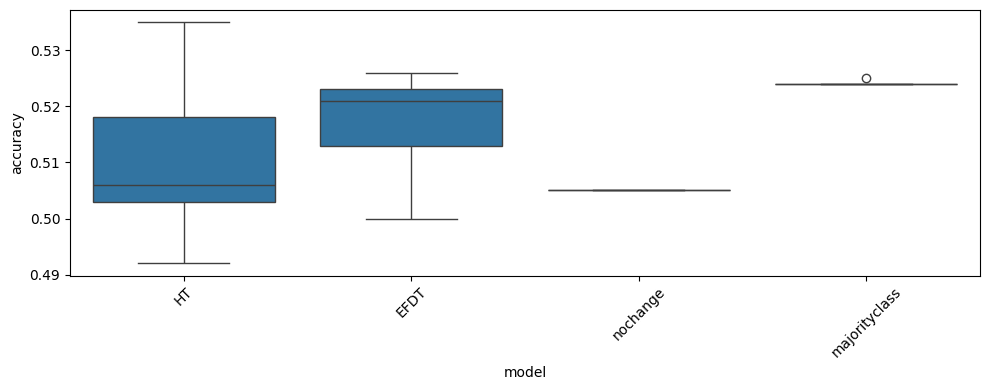

In [12]:
result_df_bis = result_df.copy()
result_df_bis['model_name'] = result_df_bis['model_name'].apply(lambda model_name: 'HT' if model_name=='hoeffdingtreeclassifier' else
                                                                                   'EFDT' if model_name=='extremelyfastdecisiontreeclassifier' else 
                                                                                   model_name)
plt.figure(figsize=(10, 4))
sns.boxplot(x='model_name', y="accuracy", data=result_df_bis)
# plt.title("Accuracy by model")
plt.xticks(rotation=45)
plt.xlabel('model')
plt.tight_layout()
plt.savefig('result_df_images_to_report/real_data_drift_comparison_model_vs_acc.png')
plt.show()

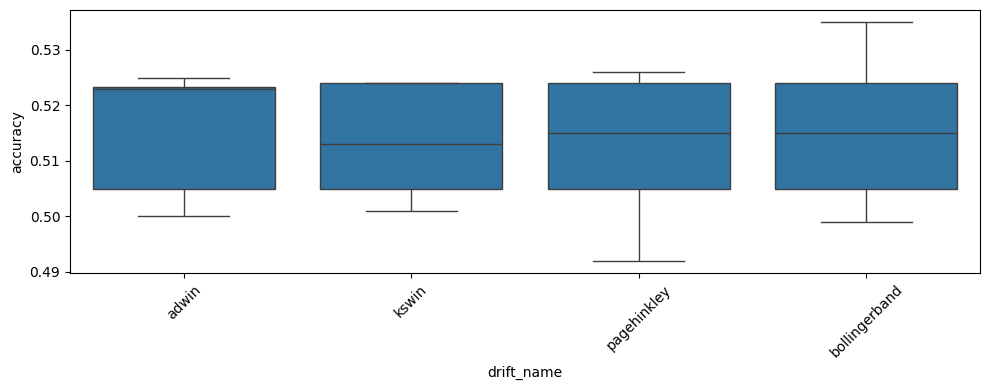

In [ ]:
plt.figure(figsize=(10, 4))
sns.boxplot(x='drift_name', y="accuracy", data=result_df)
# plt.title("Accuracy by drift detector")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('result_df_images_to_report/real_data_drift_comparison_drift_detector_vs_acc.png')
plt.show()

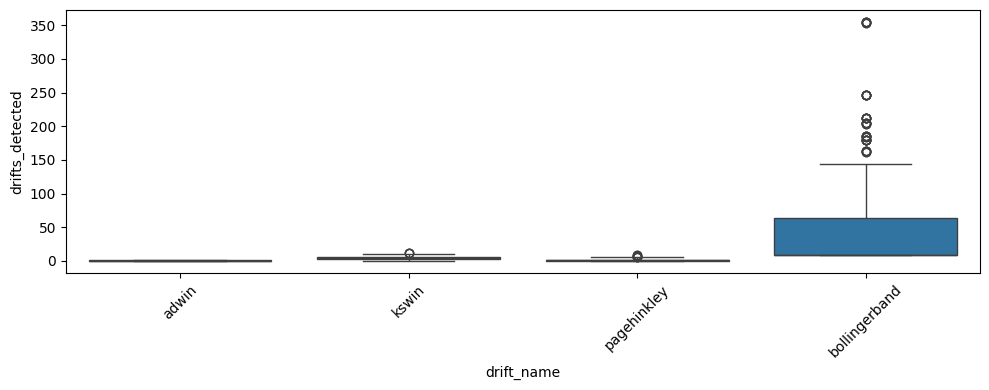

In [15]:
plt.figure(figsize=(10, 4))
sns.boxplot(x='drift_name', y="drifts_detected", data=result_df)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('result_df_images_to_report/real_data_drift_comparison_drift_detector_vs_drift_detected.png')
plt.show()